In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
I = cv2.imread('data/I.jpg', cv2.IMREAD_GRAYSCALE) # wczesniejsza
J = cv2.imread('data/J.jpg', cv2.IMREAD_GRAYSCALE) # pozniejsza

# resize to half the size
I = cv2.resize(I, (0,0), fx=0.5, fy=0.5)
J = cv2.resize(J, (0,0), fx=0.5, fy=0.5)

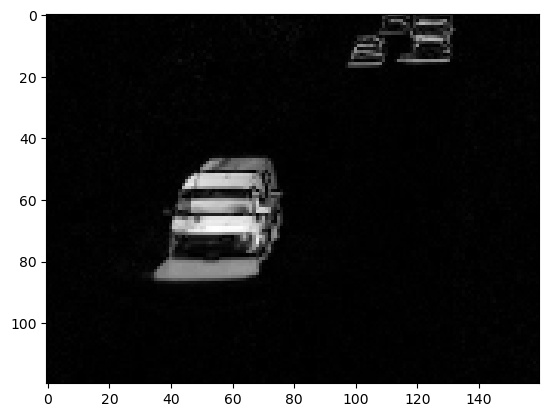

In [14]:
plt.imshow(cv2.absdiff(I, J), cmap='gray')

In [22]:
def of(I_org, I, J, W2=3, dY=3, dX=3):
    u = np.zeros(I.shape)
    v = np.zeros(I.shape)

    # iterate over the image (W2 to avoid edge cases)
    for y in range(W2, I.shape[0] - W2 - 1):
        for x in range(W2, I.shape[1] - W2 - 1):
            # get the window from the first image
            I0 = np.float32(I[y-W2:y+W2+1, x-W2:x+W2+1])

            lowest_dist = np.inf

            # check J(y, x) surroundings
            for y2 in range(y-dY, y+dY+1):
                for x2 in range(x-dX, x+dX+1):
                    # check if the window is inside the image
                    if not (y2-W2 >= 0 and y2+W2+1 < J.shape[0] and x2-W2 >= 0 and x2+W2+1 < J.shape[1]):
                        continue
                    
                    # get the J window
                    J0 = np.float32(J[y2-W2:y2+W2+1, x2-W2:x2+W2+1])

                    # calculate the distance
                    dist = np.sum(np.square(J0 - I0))

                    # if the distance is lower than the previous lowest, save it
                    if dist < lowest_dist:
                        lowest_dist = dist
                        u[y, x] = x2 - x
                        v[y, x] = y2 - y
    return u, v

def visualize_flow(u, v, YX, name):
    # convert to polar coordinates
    magnitude, angle = cv2.cartToPolar(u, v)

    # create hsv image
    hsv = np.zeros((YX[0], YX[1], 3), dtype=np.uint8)

    # H channel
    hsv[:,:,0] = angle * 90 / np.pi
    # S channel
    hsv[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # V channel
    hsv[:,:,1] = 255

    # display with matplotlib
    plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
    plt.title(f'Image {name} | Size {YX}')
    plt.show()

def pyramid(im, max_scale):
    images = [im]
    for k in range(1, max_scale):
        images.append(cv2.resize(images[k-1], (0,0), fx=0.5, fy=0.5))
    return images

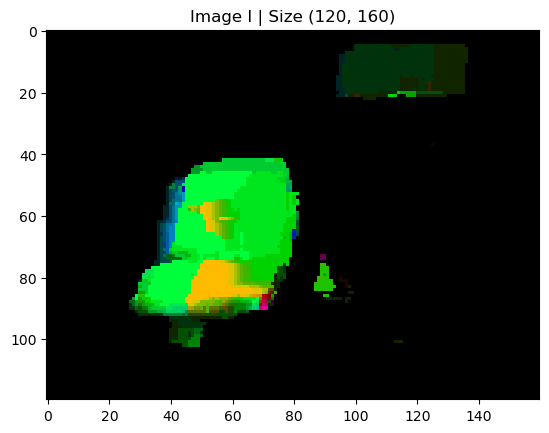

In [33]:
# calculate the optical flow
I = cv2.imread('data/I.jpg', cv2.IMREAD_GRAYSCALE)
I = cv2.resize(I, (0,0), fx=0.5, fy=0.5)

J = cv2.imread('data/J.jpg', cv2.IMREAD_GRAYSCALE)
J = cv2.resize(J, (0,0), fx=0.5, fy=0.5)
u, v = of(I, I, J, W2=5, dY=5, dX=5)
visualize_flow(u, v, I.shape, 'I')

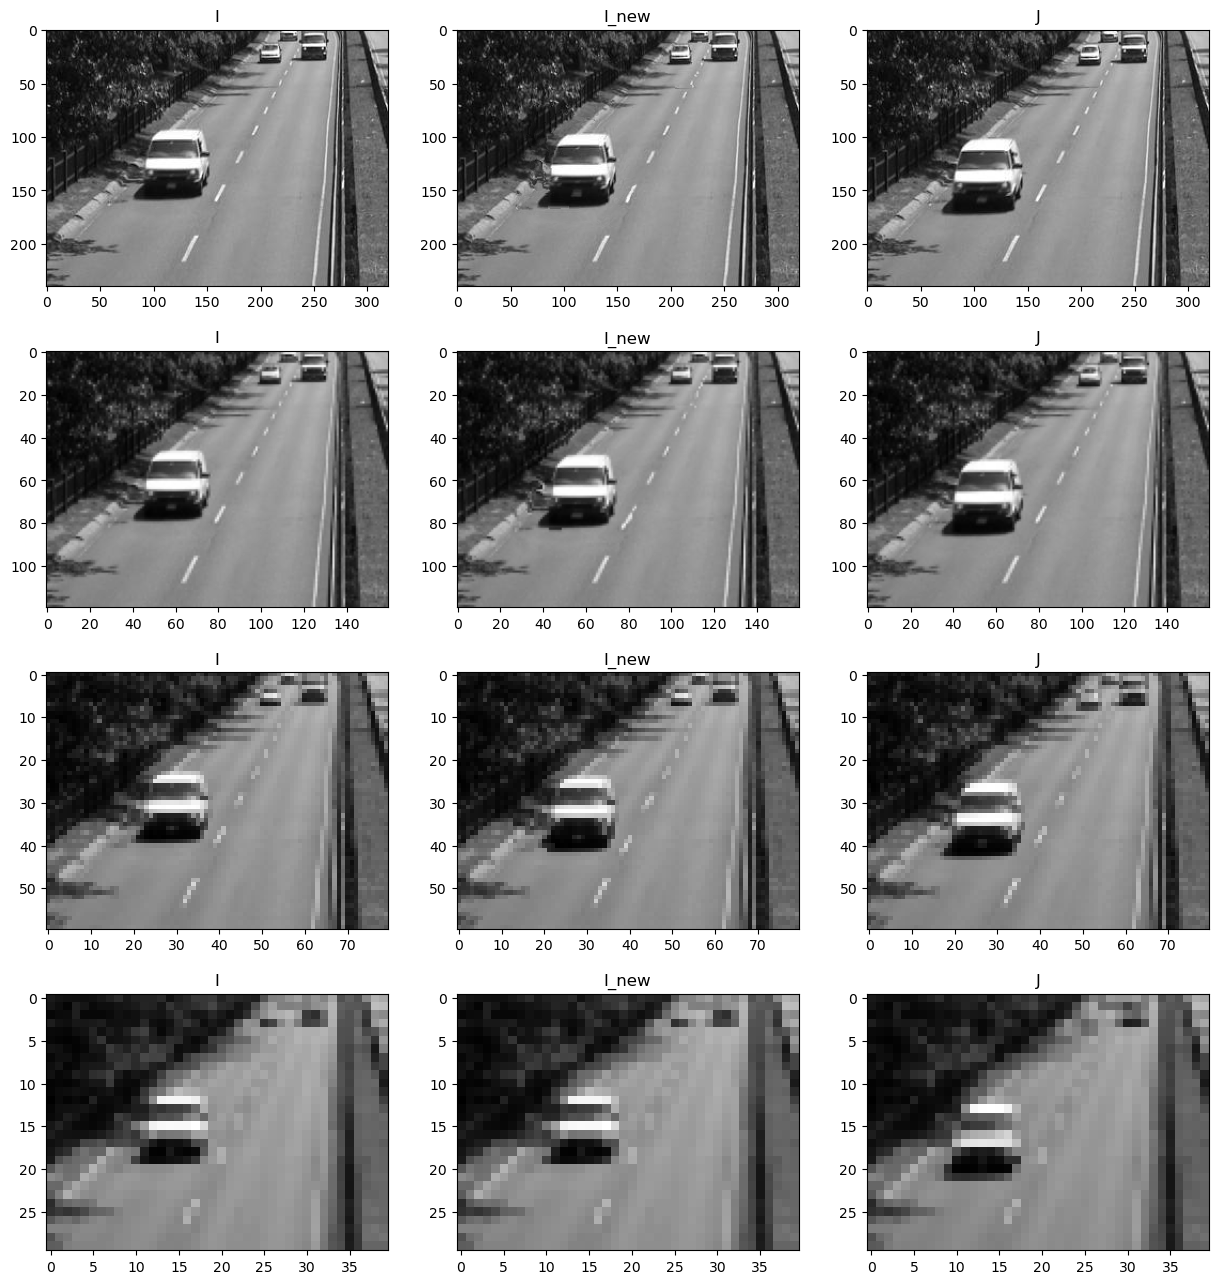

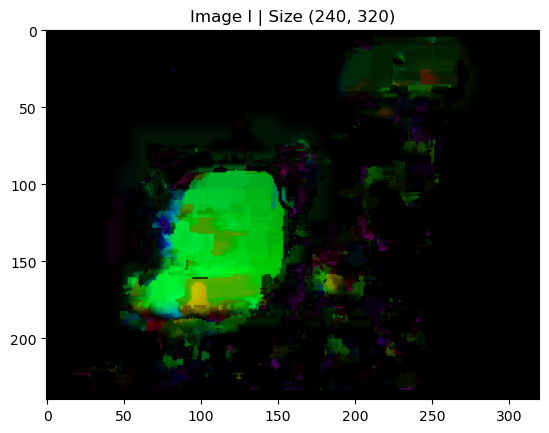

In [34]:
I = cv2.imread('data/I.jpg', cv2.IMREAD_GRAYSCALE) # wczesniejsza
J = cv2.imread('data/J.jpg', cv2.IMREAD_GRAYSCALE) # pozniejsza

# use the pyramid technique for better results
I_pyramid_images = pyramid(I, 4)
J_pyramid_images = pyramid(J, 4)

u = np.zeros(I_pyramid_images[-1].shape)
v = np.zeros(I_pyramid_images[-1].shape)

plt.figure(figsize=(15, 4*len(I_pyramid_images)))


# calculate the optical flow for each image in the pyramid (reverse order)
for i in range(len(I_pyramid_images)-1, -1, -1):
    Iimg = I_pyramid_images[i]
    Jimg = J_pyramid_images[i]

    I_new = np.copy(Iimg)

    # apply the flow to the image
    for y in range(Iimg.shape[0]):
        for x in range(Iimg.shape[1]):
            if y - int(v[y, x]) >= 0 and y - int(v[y, x]) < Iimg.shape[0] and x - int(u[y, x]) >= 0 and x - int(u[y, x]) < Iimg.shape[1]:
                I_new[y, x] = Iimg[y - int(v[y, x]), x - int(u[y, x])]

    # calculate the optical flow
    u_new, v_new = of(Iimg, I_new, Jimg, W2=5, dY=5, dX=5)
    u += u_new
    v += v_new

    # resize the u and v
    if i > 0:
        u = cv2.resize(u, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        v = cv2.resize(v, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    # visualize the images I, I_new and J in a grid
    plt.subplot(len(I_pyramid_images), 3, 3*i+1)
    plt.imshow(Iimg, cmap='gray')
    plt.title('I')
    plt.subplot(len(I_pyramid_images), 3, 3*i+2)
    plt.imshow(I_new, cmap='gray')
    plt.title('I_new')
    plt.subplot(len(I_pyramid_images), 3, 3*i+3)
    plt.imshow(Jimg, cmap='gray')
    plt.title('J')

plt.show()

visualize_flow(u, v, I.shape, 'I')

